# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.3 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.5199999883770943


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
import copy
import time
import random
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F


import matplotlib.pyplot as plt
from collections import namedtuple, deque
#from ddpg_agent import Agent
#from torchsummary import summary
%matplotlib inline
#plt.ion()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EXPERIENCE_POOL_SIZE = 100000 # define the experience pool size
BATCH_SIZE = 128 # minibatch size
LR_ACTOR = 0.0001 # actor network learning rate
LR_CRITIC = 0.0001 # critic network learning rate
WEIGHT_DECAY = 0 # L2 weight decay
LEARN_EVERY = 20 # learning interval
GAMMA = 0.99 # discount factor
TAU = 0.001 # soft update parameters
OU_SIGMA = 0.2 # Ornstein-Uhlenbeck noise parameter, volatility
OU_THETA = 0.15 # Ornstein-Uhlenbeck noise parameter, mean recovery speed
EPS_START = 1.0 # Initial value of ε during noise attenuation
EPS_DECAY = 0.00003 #to decay exploration as it learns
EPS_FINAL = 0.05 # final value of ε after attenuation
GOAL_SCORE = 30 # goal score
WINDOW_LENGTH = 100 # limited number of actions
PRINT_EVERY = 10 # print the score every tenth time
ADD_NOISE = True # add noise

In [9]:
### Construction of neural network ###
def hidden_init(layer):
    x = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(x)
    return (-lim, lim)

class Network(nn.Module): 
    def __init__(self,input_dim,output_dim,seed=0,fc1_units=256,fc2_units=128,fc3_units=128,actor=False):
        super(Network, self).__init__()
        self.actor = actor
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_dim, fc1_units)
        if self.actor:  
            self.fc2 = nn.Linear(fc1_units, fc2_units)
            self.fc3 = nn.Linear(fc2_units, fc3_units)
            self.fc4 = nn.Linear(fc3_units, output_dim)
        else:
            self.fc2 = nn.Linear(fc1_units+action_size, fc2_units)
            self.fc3 = nn.Linear(fc2_units, fc3_units)
            self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)
    def forward(self, state, action):
        if self.actor:  
            h1 = F.relu(self.fc1(state))
            h2 = F.relu(self.fc2(h1))
            h3 = F.relu(self.fc3(h2))
            h4 = torch.tanh(self.fc4(h3))
            return h4
        else:  
            h1 = F.relu(self.fc1(state))
            h2 = torch.cat((h1, action), dim=1)
            h3 = F.relu(self.fc2(h2))
            h4 = F.relu(self.fc3(h3))
            return self.fc4(h4)

In [10]:
class Agent():
    
    def __init__(self, state_size, action_size, n_agents=1, seed=0):
        self.timesteps = 0  
        self.state_size = state_size
        self.action_size = action_size
        self.seed = np.random.seed(seed)
        self.n_agents = n_agents
        # Actor Neural network building
        self.actor = Network(state_size, action_size, seed, actor=True).to(device)
        self.actor_target = Network(state_size, action_size, seed, actor=True).to(device)
        # Critic Neural network building
        self.critic = Network(state_size, action_size, seed).to(device)
        self.critic_target = Network(state_size, action_size, seed).to(device)
        # Optimizer definition
        self.actor_optimizer = Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        # Make sure target is initialized with the same weight as the source
        self.hard_copy_weights(self.actor_target, self.actor)
        self.hard_copy_weights(self.critic_target, self.critic)
        # epsilon attenuation
        self.eps = EPS_START
        self.eps_decay = EPS_DECAY
        # Motion noise
        self.noise = OUNoise(action_size, seed)
        # Experience Replay
        self.memory = Experience_Replay(action_size, EXPERIENCE_POOL_SIZE, BATCH_SIZE, seed)
        
    def step(self, states, actions, rewards, next_states, dones):
        self.timesteps += 1
        for i in range(self.n_agents):# Save experience
            self.memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i])
        # Start learning the experience pool data when there are enough samples
        if (len(self.memory) > BATCH_SIZE) and (self.timesteps % 20 == 0):
            for _ in range(10):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
                
    # Executing the current policy outputs the action
    def act(self, states, add_noise=True):
        states = torch.from_numpy(states).float().to(device)
        self.actor.eval()
        # Organize state action pairs and pass them to the actor network to output the next action
        with torch.no_grad():
            actions = self.actor(states,1).cpu().data.numpy()
        self.actor.train()
        if add_noise and (np.random.random() < self.eps):
            actions += [self.noise.sample() for _ in range(self.n_agents)]
            #update the exploration parameter
            self.eps -= self.eps_decay
            if self.eps < EPS_FINAL:
                self.eps = EPS_FINAL
        return np.clip(actions, -1, 1)
    
    def reset(self):
        self.noise.reset()
    
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        ###  critic network parameter update   ###
        actions_next = self.actor_target(next_states,actions)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Calculate critic network loss
        Q_expected = self.critic(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        ###  actor network parameter update  ###
        actions_pred = self.actor(states,actions)
        actor_loss = -self.critic(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        ###  Soft update ###
        self.soft_update(self.critic, self.critic_target, TAU)
        self.soft_update(self.actor, self.actor_target, TAU)
        
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    def hard_copy_weights(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data) 
    def device(self):
        return device
    
### OU Noise function ###                
class OUNoise:
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = np.random.seed(seed)
        random.seed(seed)
        self.reset()
    def reset(self):
        self.state = copy.copy(self.mu)
    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([np.random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

### Experience Replay function ###    
class Experience_Replay:
    def __init__(self, action_size, EXPERIENCE_POOL_SIZE, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=EXPERIENCE_POOL_SIZE)  # internal memory 
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = np.random.seed(seed)
        random.seed(seed)
    def add(self, state, action, reward, next_state, done):# Add sample
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    def sample(self):            # Random sampling
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)
    def __len__(self):
        return len(self.memory)

In [11]:
agent = Agent(state_size=state_size, action_size=action_size, seed=42)
env_info = env.reset(train_mode=True)[brain_name] 
n_episodes=1000
max_t=1000000
score_target=GOAL_SCORE
scores_window = deque(maxlen=WINDOW_LENGTH) 
scores_all = []        
best_average_score = -np.inf
### Start loop learning ###
for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name] # Reset environment
    states = env_info.vector_observations        # Get states
    agent.reset()
    scores = np.zeros(num_agents) 
    for t in range(max_t):
        actions = agent.act(states,ADD_NOISE)                # Select proxy actions and combine them
        env_info = env.step(actions)[brain_name]             # Output two actions to the environment together
        next_states = env_info.vector_observations           # Output next state
        rewards = env_info.rewards                           # Get reward
        dones = env_info.local_done                          # See if the plot is over
        agent.step(states, actions, rewards, next_states, dones)# Agent learning
        scores += np.array(rewards)                          # Update record score
        states = next_states                                 # Update status characteristics
        if np.any(dones):
            break
    # Record scores for easy mapping
    ep_score = np.mean(scores) 
    scores_window.append(ep_score)
    scores_all.append(ep_score)
    average_score = np.mean(scores_window)
    # Determine if environmental issues are resolved and save the model
    print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, ep_score), end="")
    if i_episode % PRINT_EVERY == 0:
        print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, ep_score))
    if average_score >= score_target:
        print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode, average_score, ep_score))
        torch.save(agent.actor.state_dict(), 'actor_weight.pth')
        torch.save(agent.critic.state_dict(), 'critic_weight.pth')
        break

Episode: 10	Average Score: 0.34	Current Score: 0.72
Episode: 20	Average Score: 0.50	Current Score: 0.28
Episode: 30	Average Score: 0.68	Current Score: 0.06
Episode: 40	Average Score: 1.13	Current Score: 8.54
Episode: 50	Average Score: 1.58	Current Score: 4.58
Episode: 60	Average Score: 2.11	Current Score: 4.07
Episode: 70	Average Score: 2.51	Current Score: 4.692
Episode: 80	Average Score: 2.86	Current Score: 8.03
Episode: 90	Average Score: 3.46	Current Score: 7.658
Episode: 100	Average Score: 4.02	Current Score: 14.94
Episode: 110	Average Score: 4.82	Current Score: 14.25
Episode: 120	Average Score: 5.77	Current Score: 11.94
Episode: 130	Average Score: 7.08	Current Score: 11.59
Episode: 140	Average Score: 8.27	Current Score: 15.34
Episode: 150	Average Score: 9.57	Current Score: 18.12
Episode: 160	Average Score: 10.64	Current Score: 18.32
Episode: 170	Average Score: 11.79	Current Score: 17.79
Episode: 180	Average Score: 12.95	Current Score: 13.24
Episode: 190	Average Score: 14.08	Current

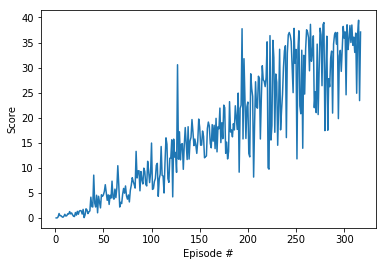

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_all)+1), scores_all)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [19]:
env.close()